In [0]:
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time

print(f'PyTorch version: {torch.__version__}')

if torch.cuda.is_available()==True:
    use_cuda = True
    print(f'GPU available: {torch.cuda.get_device_name(0)} ({torch.cuda.device_count()} count)')

PyTorch version: 1.3.1+cu100
GPU available: Tesla K80 (1 count)


In [0]:
def default_device():
    if torch.cuda.is_available()==True:
        dflt_device = torch.device('cuda')
    else:
        dflt_device = torch.device('cpu')

    return dflt_device


def load_data(dir_in_str):
    E, S_pre, durations_list, min_pitch, max_pitch = torch.load(dir_in_str)
    E = E.to(device=dflt_device)
    S = []
    for tensor in S_pre:
        S.append(tensor.to(device=dflt_device))

    return E, S, durations_list, min_pitch, max_pitch


def dimensions(E,S): 
    
    num_event_examples, num_events , event_emb_size  = E.shape    
    num_seq_examples = len(S)
    signal_emb_size = S[0].size(1)
    
    dims = [num_event_examples, num_events , event_emb_size, num_seq_examples, signal_emb_size ]
    
    return dims
  

def prepare_data(S):
  S_pre_input = []
  first_row = torch.zeros(1,signal_emb_size).to(device=dflt_device)
  for tensor in S:
      expanded_tensor = torch.cat((first_row, tensor), dim=0)
      new_tensor = expanded_tensor[:-1,:]
      S_pre_input.append(new_tensor)
      
  conditioning_idxs_vectors = [] 
  for tensor in S:
      conditioning_indices = torch.zeros(tensor.shape[0],1).to(device=dflt_device)
      cumulative_duration = 0
      for row in range(0,tensor.shape[0]-1):
          vector = tensor[row,:]        
          pitch_idx, rhythm_idx = list((vector != 0).nonzero())
          pitch_idx, rhythm_idx = int(pitch_idx), int(rhythm_idx)
          duration_type_idx = rhythm_idx - rhythm_idx_ini
          duration_type = durations_list[duration_type_idx]
          cumulative_duration += duration_type
          conditioning_indices[row+1] = int(cumulative_duration)
      conditioning_idxs_vectors.append(conditioning_indices)

  lengths_list = []
  for tensor in S:
      lengths_list.append(tensor.shape[0])

  S_padded = torch.nn.utils.rnn.pad_sequence(S, batch_first=True)
  S_packed = torch.nn.utils.rnn.pack_padded_sequence(S_padded, batch_first=True, lengths=lengths_list, enforce_sorted=False)

  return S_packed, S_padded, S_pre_input, lengths_list, conditioning_idxs_vectors


def create_placing_matrices(conditioning_idxs_vectors, num_events):
    placing_conditioning_matrices = []
    for vector in conditioning_idxs_vectors:
        placing_matrix = torch.zeros(vector.shape[0], num_events).to(device=dflt_device)
        for i in range(vector.shape[0]):
            placing_matrix[i, int(vector[i])] = 1
        placing_conditioning_matrices.append(placing_matrix)
        
    return placing_conditioning_matrices


def concatenate_conditioning(S_pre_input, \
                             encoded_conditioning, \
                             placing_conditioning_matrices, lengths_list):    
  S_conditioned = []
  for idx, tensor in enumerate(S_pre_input):
    placing_matrix = placing_conditioning_matrices[idx]
    dynamic_conditioning = torch.mm(placing_matrix, encoded_conditioning[idx,:,:])
    concatenated_input = torch.cat((tensor, dynamic_conditioning), dim=1)
    S_conditioned.append(concatenated_input)
  S_input = torch.nn.utils.rnn.pad_sequence(S_conditioned, batch_first=True)
  S_input = torch.nn.utils.rnn.pack_padded_sequence(S_input, batch_first=True, lengths=lengths_list, enforce_sorted=False)

  return S_input


In [0]:
class event_net(torch.nn.Module):
    
    def __init__(self, event_emb_size, event_hidden_size, event_output_size, \
                 num_event_layers, num_event_examples, num_directions):
        super(event_net, self).__init__()

        self.event_emb_size     = event_emb_size
        self.event_hidden_size  = event_hidden_size
        self.event_output_size  = event_output_size
        self.num_event_layers   = num_event_layers
        self.num_event_examples = num_event_examples
        self.num_directions     = num_directions
        
        self.event_lstm   = torch.nn.LSTM(self.event_emb_size, self.event_hidden_size, \
                                    self.num_event_layers, batch_first=True, bidirectional=True)
        self.event_linear = torch.nn.Linear(self.event_hidden_size*num_directions, self.event_output_size)
        
        self.initHidden  = self.init_hidden()
    
    def init_hidden(self):
        h_ini = (torch.zeros(self.num_event_layers*num_directions, self.num_event_examples, self.event_hidden_size),\
              torch.zeros(self.num_event_layers*num_directions, self.num_event_examples, self.event_hidden_size) )
          
    def forward(self, Events):
        event_lstm_out, event_hidden = self.event_lstm(Events, self.initHidden)
        linear_output = self.event_linear(event_lstm_out*num_event_layers)
        event_output = torch.sigmoid(linear_output)
        
        return event_output


class signal_net(torch.nn.Module):
    def __init__(self, signal_emb_size, conditioning_size, signal_hidden_size, \
                 signal_output_size, num_signal_layers, num_signal_examples):
        super(signal_net, self).__init__()
        
        self.signal_emb_size     = signal_emb_size
        self.conditioning_size   = conditioning_size
        self.signal_hidden_size  = signal_hidden_size
        self.signal_output_size  = signal_output_size
        self.num_signal_layers   = num_signal_layers
        self.num_signal_examples = num_signal_examples
        
        self.signal_lstm   = torch.nn.LSTM(self.signal_emb_size+self.conditioning_size, self.signal_hidden_size, \
                                    self.num_signal_layers, batch_first=True)
        self.signal_linear = torch.nn.Linear(self.signal_hidden_size, self.signal_output_size)
        
    def forward(self, S_input, prev_hidden):
        signal_lstm_out, signal_hidden = self.signal_lstm(S_input, prev_hidden)
        signal_linear_output = self.signal_linear(signal_lstm_out.data)
        #signal_output = torch.sigmoid(signal_linear_output)
        
        return signal_linear_output, signal_hidden



In [0]:
dflt_device = default_device()

E, S, durations_list, min_pitch, max_pitch = load_data('Parker_Dataset_unshuffled.pt')
#E, S = E[0:6,:,:], S[0:6]

num_event_examples, num_events , event_emb_size, num_signal_examples, signal_emb_size = dimensions(E,S)
rhythm_idx_ini = max_pitch - min_pitch + 1 + True

S_packed, S_padded, S_pre_input, lengths_list, conditioning_idxs_vectors = prepare_data(S)
placing_conditioning_matrices = create_placing_matrices(conditioning_idxs_vectors, num_events)

In [0]:
torch.manual_seed(1)

#Choose dimensions for event LSTM
num_event_layers = 1
event_hidden_size = 32
num_directions = 2
event_output_size = 48

#Choose dimensions for signal LSTM
num_signal_layers  = 1
signal_hidden_size = 128
signal_output_size = 89
conditioning_size  = event_output_size

#Create 1st LSTM
event_forward_pass = event_net(event_emb_size, event_hidden_size, event_output_size, \
                 num_event_layers, num_event_examples, num_directions)
event_forward_pass = event_forward_pass.to(device=dflt_device)

#Create 2nd LSTM
signal_forward_pass = signal_net(signal_emb_size, conditioning_size, signal_hidden_size, \
                 signal_output_size, num_signal_layers, num_signal_examples)
signal_forward_pass = signal_forward_pass.to(device=dflt_device)
signal_h_ini = (torch.zeros(num_signal_layers, num_signal_examples, signal_hidden_size).to(device=dflt_device),\
              torch.zeros(num_signal_layers, num_signal_examples, signal_hidden_size).to(device=dflt_device) )

weights = list(event_forward_pass.parameters()) + list(signal_forward_pass.parameters())

#Number of parameters
num_event_parameters = sum([p.numel() for p in event_forward_pass.parameters()])
print(f'Number of parameters in LSTM of events: {num_event_parameters}')

num_signal_parameters = sum([p.numel() for p in signal_forward_pass.parameters()])
print(f'Number of parameters in LSTM of signals: {num_signal_parameters}')

print(f'Total number of parameters: {num_event_parameters+num_signal_parameters}')

Number of parameters in LSTM of events: 17968
Number of parameters in LSTM of signals: 148185
Total number of parameters: 166153


Epoch: 1, Loss: 0.6899568438529968  (Learning rate: [0.05], Time: 3.2956s
Epoch: 2, Loss: 0.10421120375394821  (Learning rate: [0.05], Time: 3.1915s
Epoch: 3, Loss: 0.08072568476200104  (Learning rate: [0.05], Time: 3.1769s
Epoch: 4, Loss: 0.09297320991754532  (Learning rate: [0.05], Time: 3.2042s
Epoch: 5, Loss: 0.08463162928819656  (Learning rate: [0.05], Time: 3.1902s
Epoch: 6, Loss: 0.08150676637887955  (Learning rate: [0.05], Time: 3.1886s
Epoch: 7, Loss: 0.08206646144390106  (Learning rate: [0.05], Time: 3.1866s
Epoch: 8, Loss: 0.08196084201335907  (Learning rate: [0.05], Time: 3.1857s
Epoch: 9, Loss: 0.0811527818441391  (Learning rate: [0.05], Time: 3.1879s
Epoch: 10, Loss: 0.0781247541308403  (Learning rate: [0.05], Time: 3.1993s
Epoch: 11, Loss: 0.07729245722293854  (Learning rate: [0.05], Time: 3.1924s
Epoch: 12, Loss: 0.07774801552295685  (Learning rate: [0.05], Time: 3.1961s
Epoch: 13, Loss: 0.07783713191747665  (Learning rate: [0.05], Time: 3.1933s
Epoch: 14, Loss: 0.07746

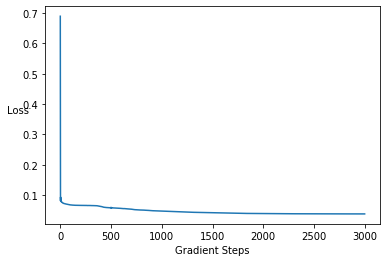

In [0]:
LR          = 0.05
epochs      = 3000
WeightDecay = 1e-8
Momentum    = 0.9

loss_func    = torch.nn.BCEWithLogitsLoss()
#loss_func    = torch.nn.MSELoss()
optimizer    = torch.optim.Adam(weights, lr=LR, betas=(0.9, 0.999), eps=1e-8, weight_decay = WeightDecay )
#optimizer    = torch.optim.RMSprop(weights,lr=LR, alpha=0.99, eps=1e-8, weight_decay = WeightDecay, momentum = Momentum, centered=True)
scheduler    = torch.optim.lr_scheduler.StepLR(optimizer, step_size=300, gamma=0.5, last_epoch=-1)
#scheduler    = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0.000001, last_epoch=-1)

loss_hist  = []
for epoch in range(1, epochs+1):
  t = time.time()
  optimizer.zero_grad()
  encoded_conditioning = event_forward_pass(E)
  S_input = concatenate_conditioning(S_pre_input, encoded_conditioning, placing_conditioning_matrices, lengths_list)
  S_hat, _ = signal_forward_pass(S_input, signal_h_ini)
  Loss = loss_func(S_hat, S_packed.data)
  Loss.backward()
  optimizer.step()
  loss_hist.append(Loss.item())
  scheduler.step()
  #if epoch%200==0:
  print(f'Epoch: {epoch}, Loss: {Loss}  (Learning rate: {scheduler.get_lr()}, Time: {round(time.time()-t,4)}s')

plt.plot(loss_hist[:])
plt.xlabel('Gradient Steps')
vert_label=plt.ylabel('Loss')
vert_label.set_rotation(0)

In [0]:
def net_generate(e, sample=False):
  event_steps = e.shape[0]
  encoded_conditioning = event_forward_pass(e.view(1, event_steps, -1))
  hidden = (signal_h_ini[0][0,0,:].view(num_signal_layers, 1, signal_hidden_size), \
           signal_h_ini[1][0,0,:].view(num_signal_layers, 1, signal_hidden_size))
  signal_prev = torch.zeros(1, signal_emb_size).to(device=dflt_device)
  prediction_list     = []
  raw_prediction_list = []
  cumulative_duration = 0
  while cumulative_duration <= float(event_steps-1):
    dynamic_idx = int(cumulative_duration)
    conditioning = encoded_conditioning[0, dynamic_idx, :].view(1,-1)
    signal_input = torch.cat((signal_prev, conditioning), dim=1)
    signal_input = signal_input.view(1,1,-1)
    s_hat_pre, hidden = signal_forward_pass(signal_input, hidden )
    #s_hat = torch.sigmoid(s_hat)  #smoothens the future prob dist
    s_hat_pitch  = F.softmax( s_hat_pre[0, 0, 0:rhythm_idx_ini], dim = 0 )
    s_hat_rhythm = F.softmax( s_hat_pre[0, 0, rhythm_idx_ini:], dim = 0 )
    
    raw_s_hat = torch.cat ((s_hat_pitch,s_hat_rhythm) , dim = 0).view(1,-1)
    raw_prediction_list.append(raw_s_hat)        
    
    if sample == False:
        note_max , note_argmax = s_hat_pitch.max(0)
        rhythm_max , rhythm_argmax = s_hat_rhythm.max(0)
        
    if sample == True:
        note_prob_dist = torch.distributions.Categorical(s_hat_pitch)
        note_argmax = int(note_prob_dist.sample())
        rhythm_prob_dist = torch.distributions.Categorical(s_hat_rhythm)
        rhythm_argmax = int(rhythm_prob_dist.sample())
    
    s_hat = torch.zeros(1, signal_emb_size)
    s_hat[0, int(note_argmax)] = 1  
    s_hat[0, int(rhythm_idx_ini + int(rhythm_argmax))] = 1                    
    prediction_list.append(s_hat)

    #pitch_idx, rhythm_idx = list((s_hat != 0).nonzero())
    #pitch_idx, rhythm_idx = int(pitch_idx), int(rhythm_idx)
    #duration_type_idx = rhythm_argmax - rhythm_idx_ini
    duration_type = durations_list[rhythm_argmax]
    cumulative_duration += duration_type

    signal_prev  = s_hat.to(device=dflt_device)

  prediction = torch.cat(prediction_list)
  raw_prediction = torch.cat(raw_prediction_list)

  return prediction , raw_prediction

e = E[1,:,:]
prediction , raw_prediction = net_generate(e, sample=False)

In [0]:
print(prediction.shape)

torch.Size([61, 89])


In [0]:
conditioning_prueba = event_forward_pass(E[0,:,:].view(1,16,-1))

In [0]:
conditioning_prueba[0,0,:].shape

In [0]:
input_prueba = torch.cat( (S_input.data[0,0:89], conditioning_prueba[0,0,:]), dim=0)

In [0]:
input_prueba = input_prueba.view(1,1,105)

In [0]:
prueba_h_ini = (signal_h_ini[0][0,0,:].view(1,1,128), signal_h_ini[1][0,0,:].view(1,1,128))

In [0]:
s_hat, hidden = signal_forward_pass(input_prueba, prueba_h_ini )
s_hat = torch.sigmoid(s_hat)
s_hat.shape

In [0]:
s_hat = 1*(s_hat>=0.5)
s_hat = s_hat.type(torch.FloatTensor)
s_hat = s_hat.to(device=dflt_device)
print(s_hat.shape)
conditioning_prueba[0,0,:].view(1,1,16).shape

In [0]:
s_next = torch.cat((s_hat, conditioning_prueba[0,0,:].view(1,1,16)), dim=2)

In [0]:
s_hat2, hidden = signal_forward_pass(s_next, hidden )
s_hat2 = torch.sigmoid(s_hat2)

In [0]:
s_hat1, hidden = signal_forward_pass(input_prueba, prueba_h_ini )
s_hat1 = torch.sigmoid(s_hat1)

In [0]:
s_hat1